This experiment focus on modelling specifically with **space heating** as the variable

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from skforecast.model_selection import backtesting_forecaster
from skforecast.ForecasterAutoreg import ForecasterAutoreg

import plotly
import plotly.graph_objects as go


from astral import LocationInfo
from astral.sun import sun


In [2]:
from custom_utils import *

In [3]:
def get_raw_data():
    data_path = "./../data/"
    file_name = "data.csv"
    data = pd.read_csv(data_path + file_name)
    data = first_preprocess(data, data_path)
    return data

In [4]:
data = get_raw_data()
data.head()

d:\RA_work\timeseries_data\notebooks\custom_utils.py:85: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data[column] = data[column].interpolate(method="linear", limit_direction="both")


,space_heating,hot_water,sockets,lighting,bld_engcons,car_chargers,weekend,bank_holiday,day_of_week,day_of_month,...,forecast_weathertype,forecast_windspeed,forecast_uvindex,forecast_precipitationprobability,forecast_visibility,week_of_year,sine_hour,cos_hour,sine_forecast_winddirection,cos_forecast_winddirection
datetime,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00+00:00,3.425193,0.000000,0.049433,0.154873,3.629499,0.0,0,1,5,1,...,2.0,11.0,0.0,0.0,5,53,0.000000,1.000000,0.000000,1.00000
2021-01-01 01:00:00+00:00,4.012907,0.000000,0.047753,0.154846,4.215506,0.0,0,1,5,1,...,2.0,11.0,0.0,0.0,5,53,0.258819,0.965926,0.000000,1.00000
2021-01-01 02:00:00+00:00,5.342417,0.444782,0.051869,0.154997,5.994066,0.0,0,1,5,1,...,2.0,11.0,0.0,1.0,5,53,0.500000,0.866025,0.000000,1.00000
2021-01-01 03:00:00+00:00,5.756598,0.000000,0.043028,0.154626,5.954252,0.0,0,1,5,1,...,0.0,11.0,0.0,1.0,5,53,0.707107,0.707107,-0.382683,0.92388
2021-01-01 04:00:00+00:00,5.415492,0.000000,0.050306,0.154498,5.620296,0.0,0,1,5,1,...,0.0,11.0,0.0,1.0,5,53,0.866025,0.500000,-0.382683,0.92388


In [5]:
data.columns

Index(['space_heating', 'hot_water', 'sockets', 'lighting', 'bld_engcons',
       'car_chargers', 'weekend', 'bank_holiday', 'day_of_week',
       'day_of_month', 'month', 'year', 'forecast_temperature',
       'forecast_feelslike', 'forecast_weathertype', 'forecast_windspeed',
       'forecast_uvindex', 'forecast_precipitationprobability',
       'forecast_visibility', 'week_of_year', 'sine_hour', 'cos_hour',
       'sine_forecast_winddirection', 'cos_forecast_winddirection'],
      dtype='object')

In [6]:
exo_columns = ['forecast_temperature', 'forecast_feelslike', 
               'forecast_weathertype',
       # 'forecast_windspeed', 
       # 'forecast_uvindex',
       #'forecast_precipitationprobability', 'forecast_visibility', 
       # 'daylight_hours', 'is_daylight', 
       'sine_hour',
       'cos_hour', 
       # 'sine_month', 'cos_month', 
       # 'sine_day_of_week', 'cos_day_of_week', 
       # 'sine_forecast_winddirection',
       # 'cos_forecast_winddirection', 
       # 'sine_sunrise_hour', 'cos_sunrise_hour', 'sine_sunset_hour', 'cos_sunset_hour'
       ]
endo_columns = ['weekend', "day_of_week"] # 'week_of_year'] # 'bank_holiday', 'day_of_month', 'year']
target_column = ["y"]
column_name = exo_columns + endo_columns  + target_column # + ["space_heating"]
test_date = '2023-01-01'

# transform the data
sh_data = data.copy()
sh_data = sh_data.rename(columns={"hot_water": "y"})
# sh_data["y"] = sh_data["space_heating"].shift(-1)
# sh_data = sh_data.dropna(axis=0)
# sh_data_scaler, sh_transformed_data = create_std_scaler(sh_data, column_name[:-1])
# sh_target_scaler, sh_transformed_target_data = create_std_scaler(sh_data, column_name[-1])

# sh_transformed_data = pd.merge(sh_transformed_data, sh_transformed_target_data,
#                               left_index=True,
#                               right_index=True)

# # Training and testing data for comms and services
#sh_train_data = sh_transformed_data[sh_transformed_data.index < test_date][column_name]
#sh_test_data = sh_transformed_data[sh_transformed_data.index >= test_date][column_name]
#sh_train_data.shape, sh_test_data.shape


# adding baseline minimum of y

sh_data.loc[sh_data["y"] <= 0, "y"] = sh_data[sh_data["y"] > 0]["y"].min()

sh_train_data = sh_data[sh_data.index < test_date][column_name]
sh_test_data = sh_data[sh_data.index >= test_date][column_name]

In [7]:
sh_data[sh_data["y"] > 0]["y"].min()

2.9356060606060607e-05

Text(0.5, 1.0, 'Hot water distribution')

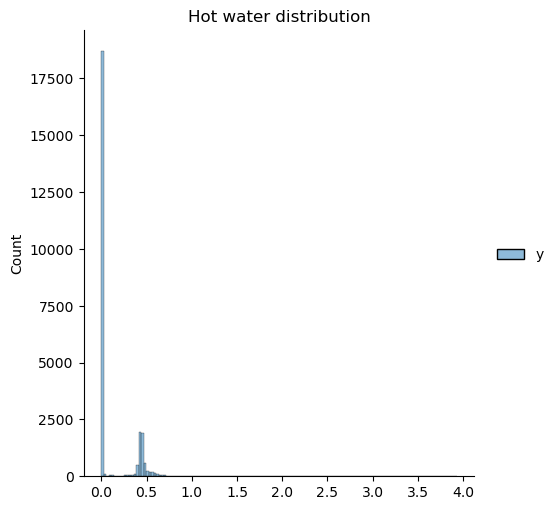

In [25]:
sns.displot(data=sh_data[["y"]])
plt.title("Hot water distribution")

(array([18628., 18748., 18871., 18993., 19113., 19236., 19358., 19478.,
        19601., 19723.]),
 [Text(18628.0, 0, '2021-01'),
  Text(18748.0, 0, '2021-05'),
  Text(18871.0, 0, '2021-09'),
  Text(18993.0, 0, '2022-01'),
  Text(19113.0, 0, '2022-05'),
  Text(19236.0, 0, '2022-09'),
  Text(19358.0, 0, '2023-01'),
  Text(19478.0, 0, '2023-05'),
  Text(19601.0, 0, '2023-09'),
  Text(19723.0, 0, '2024-01')])

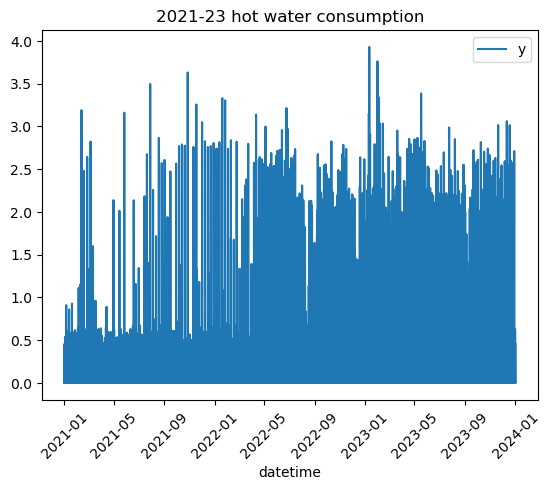

In [28]:
sns.lineplot(data=sh_data[["y"]])
plt.title("2021-23 hot water consumption")
plt.xticks(rotation=45)

In [8]:
sh_data[sh_data["y"] == 0].shape[0] / sh_data.shape[0]

0.0

In [9]:
# set the value of the forecast to minimum 300
# sh_data[sh_data["y"] == 0] = 300
sh_data[sh_data["y"] <= 1].shape

(25466, 24)

In [10]:
def custom_metric(y_true, y_pred):
    '''
    Calculate the mean squared error using only the predicted values of the last
    3 months of the year.
    '''
    return calculate_smape(actual=y_true, predicted=y_pred)

In [11]:
main_data = pd.concat([sh_train_data, sh_test_data], axis=0)
main_data.shape

(26280, 8)

In [12]:
def plot_predictions(plot_data, title_text):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=plot_data["time"].to_numpy(), y=plot_data["y"].to_numpy(),
                        mode='lines+markers',
                        name='actual'))
    fig.add_trace(go.Scatter(x=plot_data["time"].to_numpy(), y=plot_data["pred"].to_numpy(),
                        mode='lines+markers',
                        name='predictions'))
    fig.update_layout(title_text=title_text)
    fig.show()

In [13]:
# transformer_y = FunctionTransformer(func=np.log1p, inverse_func=np.expm1)
# forecaster = ForecasterAutoreg(regressor = LinearRegression(), lags = 1)
# forecaster = ForecasterAutoreg(regressor=DecisionTreeRegressor(), lags=1)
forecaster = ForecasterAutoreg(
    regressor=RandomForestRegressor(),
    lags=2
)

In [14]:
forecaster.fit(
    y=sh_train_data['y'],
    exog=sh_train_data[exo_columns + endo_columns]
)

In [15]:
metric, predictions_training = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = sh_train_data['y'],
    exog               = sh_train_data[exo_columns + endo_columns],
    steps              = 1,
    metric             = "mean_squared_error",
    refit              = False,
    n_jobs             = "auto",
    verbose            = False,
    show_progress      = True
)

print(f"Backtest error: {metric:.2f}")
predictions_training.head()

  0%|          | 0/17518 [00:00<?, ?it/s]

Backtest error: 0.01


,pred
2021-01-01 02:00:00+00:00,0.409900
2021-01-01 03:00:00+00:00,0.000032
2021-01-01 04:00:00+00:00,0.000092
2021-01-01 05:00:00+00:00,0.359520
2021-01-01 06:00:00+00:00,0.000029


In [16]:
predictions_training["y"] = sh_train_data["y"]
predictions_training = predictions_training.reset_index(drop=0)
predictions_training = predictions_training.rename(columns={"index": "time"})
# predictions_training[["pred", "y"]] = sh_target_scaler.inverse_transform(predictions_training[["pred", "y"]])
# predictions_training["pred"] = np.expm1(predictions_training["pred"])
# predictions_training["y"] = np.expm1(predictions_training["y"])
predictions_training.head()

,time,pred,y
0,2021-01-01 02:00:00+00:00,0.409900,0.444782
1,2021-01-01 03:00:00+00:00,0.000032,0.000029
2,2021-01-01 04:00:00+00:00,0.000092,0.000029
3,2021-01-01 05:00:00+00:00,0.359520,0.442276
4,2021-01-01 06:00:00+00:00,0.000029,0.000029


In [17]:
# check for the negative df
neg_df = predictions_training[predictions_training["pred"] <= 0]
neg_df.shape, neg_df.time.min(), neg_df.time.max()

((0, 3), NaT, NaT)

In [18]:
plot_predictions(predictions_training, title_text="Hot water Training data")

In [19]:
metric, predictions = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = main_data['y'],
    exog               = main_data[exo_columns + endo_columns],
    steps              = 1,
    metric             = "mean_squared_error",
    initial_train_size = main_data[main_data.index <= test_date].shape[0],
    refit              = 1000,
    fixed_train_size   = True,
    n_jobs             = 'auto',
    verbose            = False,
    show_progress      = True
)

print(f"Backtest error: {metric:.2f}")
predictions.head()

  0%|          | 0/8759 [00:00<?, ?it/s]

Backtest error: 0.12


,pred
2023-01-01 01:00:00+00:00,0.027357
2023-01-01 02:00:00+00:00,0.000568
2023-01-01 03:00:00+00:00,0.227306
2023-01-01 04:00:00+00:00,0.246898
2023-01-01 05:00:00+00:00,0.000629


In [20]:
predictions["y"] = main_data[main_data.index >= "2023-01-01"]["y"]
predictions = predictions.reset_index(drop=0)
predictions = predictions.rename(columns={"index": "time"})
# predictions[["pred", "y"]] = sh_target_scaler.inverse_transform(predictions[["pred", "y"]])

# neg_pred_pred = predictions[predictions["pred"] < 0]
# predictions.loc[predictions["pred"] <= 0.1, 'pred'] = predictions[predictions["y"] < 0.5]["y"].median()
plot_predictions(predictions, title_text="Hot water Testing data: actual vs predictions")

In [21]:
cal_metrics(predictions_training["pred"].to_numpy(), predictions_training["y"].to_numpy())

,MAE,MAPE,R2_Score,SMAPE,nRMSE,RMSE,MASE
0,0.068641,69.46,0.780013,122.84,0.038853,0.11926,-0.07


In [22]:
cal_metrics(predictions["pred"].to_numpy(), predictions["y"].to_numpy())

,MAE,MAPE,R2_Score,SMAPE,nRMSE,RMSE,MASE
0,0.2147,8236.88,-0.740613,147.77,0.12893,0.353499,-0.21


In [23]:
tmp_data = pd.concat([predictions_training, predictions], axis=0)
tmp_data = tmp_data.drop(columns=["y"], axis=1)
# tmp_data1 = main_data[main_data.index < '2021-01-01 06:00:00+00:00'][["y"]].reset_index(drop=0)
tmp_data = tmp_data.rename(columns={"y": "pred", "datetime": "time"})
# tmp_data = pd.concat([tmp_data1, tmp_data], axis=0)
tmp_data = tmp_data.set_index("time")
tmp_data = tmp_data.rename(columns={"pred": "sh_predictions"})

tmp_data.to_csv("hotwater_pred.csv", index=True)
tmp_data.shape

(26277, 1)